In [86]:
class Kmeans_Viz:
    import numpy
    import pandas
    import typing
    
    def __init__(self, data:typing.Union[numpy.ndarray, pandas.DataFrame], is_pca:bool=True):
        self.data = data
        if is_pca:
            import numpy as np
            import pandas as pd
            if type(data) == np.ndarray:
                demension = data.shape[1]
            elif type(data) == pd.DataFrame:
                demension = len(data.columns)
            
            if demension > 2:
                print(
                    """데이터 컬럼 갯수가 3개 이상입니다. pca를 진행하여 컬럼 갯수를 2개로 맞춰줍니다.
                    만약 3차원 이상의 클러스터링을 진행한다면 is_pca=False로 설정해주세요. 3차원 이상이라면 시각화가 제대로 진행되지 않을 수 있습니다."""
                )
                self.data = self.pca(data)
    
    def pca(self, data:pandas.DataFrame) -> pandas.DataFrame:
        from sklearn.decomposition import PCA
        r"""클러스터링의 경우 보통 2차원 feature를 가지고 클러스터링을 진행합니다."""
        pca = PCA(n_components=2, random_state=42)  # 주성분 개수를 지정합니다. (여기서는 2차원으로 축소)
        data_pca = pca.fit_transform(data)
        
        return data_pca
    
    def visualize_elbow_method(
        self,
        min_clusters:int = 2,
        max_clusters:int = 10,
    ):
        import matplotlib.pyplot as plt
        from sklearn.cluster import KMeans

        r"""
        실루엣 계수와 더불어 군집 갯수를 정하는 방법입니다. 응집도를 이용하여 측정합니다.
        시각화를 한 후, 그래프가 급격히 꺾이는 지점을 군집 갯수로 사용하면 됩니다.
        """
        inertia_list = []
        for n_clusters in range(min_clusters, max_clusters + 1):
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++')
            kmeans.fit(self.data)
            interia = kmeans.inertia_
            inertia_list.append(interia)
        
        plt.plot(range(min_clusters, max_clusters+1), inertia_list)
        plt.xlabel('Number of clusters')
        plt.ylabel('Inertia')
        plt.title('Elbow Method')

        plt.show()
    
    def visualize_silhouette_score(
        self,
        min_clusters:int = 2, # 최소 군집 갯수를 설정해주세요
        max_clusters:int = 10, # 최대 군집 갯수를 설정해주세요
    ) -> int:
        import numpy as np
        import matplotlib.pyplot as plt
        from sklearn.cluster import KMeans
        from sklearn.metrics import silhouette_score

        r"""
        실루엣 점수를 계산합니다. 실루엣 점수는 통상 0.5 이상이면 좋은 점수입니다.
        실루엣 스코어를 시각화한 다음 최적의 군집 갯수를 프린트합니다.
        """
        
        silhouette_scores = []

        # 각 클러스터 개수에 대해 K-means 알고리즘을 실행하고 실루엣 점수를 계산합니다.
        for n_clusters in range(min_clusters, max_clusters + 1):
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++')
            cluster_labels = kmeans.fit_predict(self.data)
            silhouette_avg = silhouette_score(self.data, cluster_labels)
            silhouette_scores.append(silhouette_avg)

        # 실루엣 점수를 시각화합니다.
        plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette score')
        plt.title('Silhouette Score for K-means Clustering')
        plt.show()
            
        print('best_silhouette_score :', np.argmax(silhouette_scores) + min_clusters)
    
    def visualize_silhouette(
        self,
        cluster_lists:typing.List[int], # 군집 갯수의 범위를 설정해주세요. e.g. 군집을 2 ~ 10개까지 설정한다면 [2, 3, 4, ..., 9, 10]
    ):
        import numpy as np
        import matplotlib.pyplot as plt
        import matplotlib.cm as cm
        from sklearn.cluster import KMeans
        from sklearn.metrics import silhouette_score, silhouette_samples
        r"""
        실루엣 계수를 시각화합니다. 군집이 적절히 나뉘고 빨간색 선인 실루엣 점수에 근접해야 좋은 군집입니다.
        """

        n_cols = len(cluster_lists)
        
        fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
        
        # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
        for idx, n_cluster in enumerate(cluster_lists):
            
            # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
            clusterer = KMeans(n_clusters = n_cluster, random_state=42, init='k-means++')
            cluster_labels = clusterer.fit_predict(self.data)
            
            sil_avg = silhouette_score(self.data, cluster_labels)
            sil_values = silhouette_samples(self.data, cluster_labels)
            
            y_lower = 10
            axs[idx].set_title(
                'Number of Cluster : '+ str(n_cluster)+'\n'
                'Silhouette Score :' + str(round(sil_avg,3))
            )
            axs[idx].set_xlabel("The silhouette coefficient values")
            axs[idx].set_ylabel("Cluster label")
            axs[idx].set_xlim([-0.1, 1])
            axs[idx].set_ylim([0, len(self.data) + (n_cluster + 1) * 10])
            axs[idx].set_yticks([])  # Clear the yaxis labels / ticks
            axs[idx].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            
            # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
            for i in range(n_cluster):
                ith_cluster_sil_values = sil_values[cluster_labels==i]
                ith_cluster_sil_values.sort()
                
                size_cluster_i = ith_cluster_sil_values.shape[0]
                y_upper = y_lower + size_cluster_i
                
                color = cm.nipy_spectral(float(i) / n_cluster)
                axs[idx].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                    facecolor=color, edgecolor=color, alpha=0.7)
                axs[idx].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                y_lower = y_upper + 10
                
            axs[idx].axvline(x=sil_avg, color="red", linestyle="--")
    
    def visualize_clusters(self, n_clusters:int):
        import numpy as np
        import pandas
        from sklearn.cluster import KMeans
        import matplotlib.pyplot as plt
        r"""위에서 구한 최적의 군집 갯수를 이용하여 Kmeans로 군집화한 후 시각화합니다."""
        
        kmeans = KMeans(n_clusters = n_clusters, random_state=42, init='k-means++')
        labels = kmeans.fit_predict(self.data)
        centers = kmeans.cluster_centers_

        # 각 군집을 시각화합니다.
        for label in np.unique(labels):
            if type(self.data) == pandas.DataFrame:
                for index in [label == labels]:
                    cluster_points = self.data[index].to_numpy()
            else:
                cluster_points = self.data[labels == label]
            center = centers[label]

            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {label}')
            plt.scatter(center[0], center[1], marker='x', color='black', label=f'Center {label}')

        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('Cluster Visualization')
        plt.legend()
        plt.show()

In [9]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1, \
                  center_box=(-10.0, 10.0), shuffle=True, random_state=42)  

X.shape, y.shape

((500, 2), (500,))

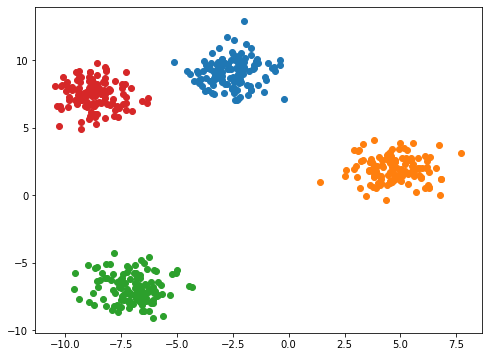

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 군집 라벨이 주어진 경우
clusters = [X[y == label] for label in np.unique(y)]
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(clusters):
    plt.scatter(cluster[:, 0], cluster[:, 1], label=y)

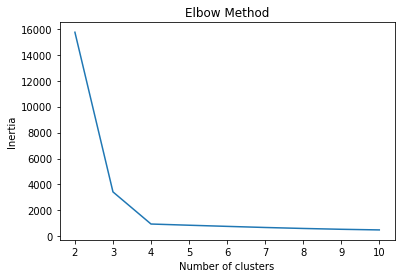

In [11]:
kmens = Kmeans_Viz(X)
kmens.visualize_elbow_method()

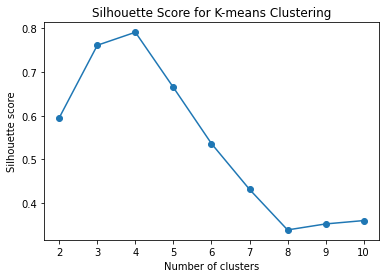

best_silhouette_score : 4


In [12]:
kmens.visualize_silhouette_score()

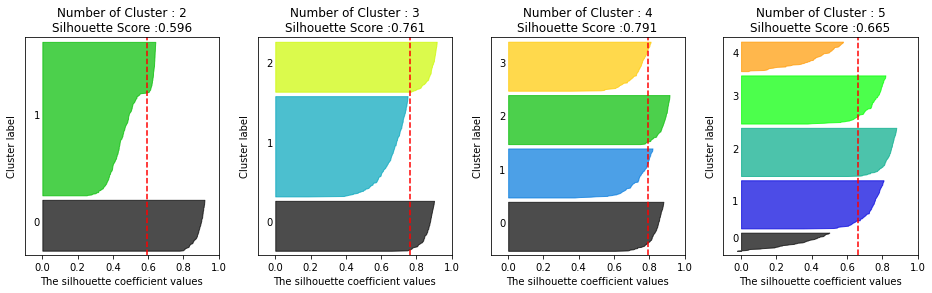

In [13]:
# 4처럼 응집도와 분리도가 좋은 군집 갯수가 가장 이상적
kmens.visualize_silhouette([2,3,4,5])

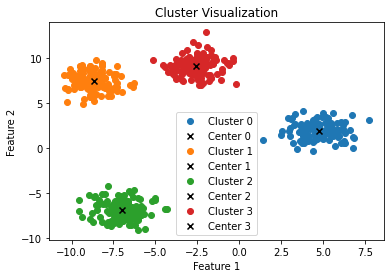

In [14]:
kmens.visualize_clusters(4)

In [89]:
# 군집 라벨이 주어진 경우
import pandas as pd

X_df, y_df = pd.DataFrame(X), pd.DataFrame(y)
y_df

,0
0,3
1,2
2,1
3,0
4,2
...,...
495,3
496,0
497,2
498,2


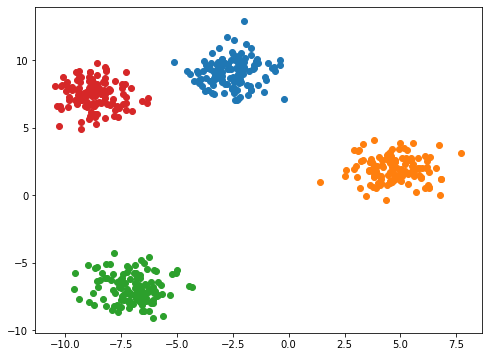

In [90]:
clusters = [[X_df.loc[index[0]] for index in [y_df == l]][0] for l in np.unique(y_df)]
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(clusters):
    plt.scatter(cluster.iloc[:, 0], cluster.iloc[:, 1], label=y)

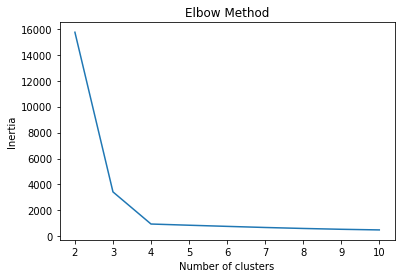

In [91]:
kmens = Kmeans_Viz(X_df)
kmens.visualize_elbow_method()

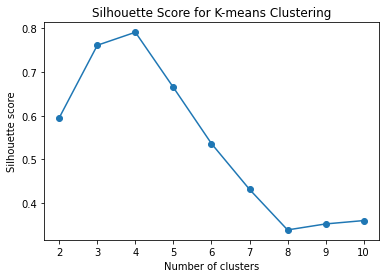

best_silhouette_score : 4


In [92]:
kmens.visualize_silhouette_score()

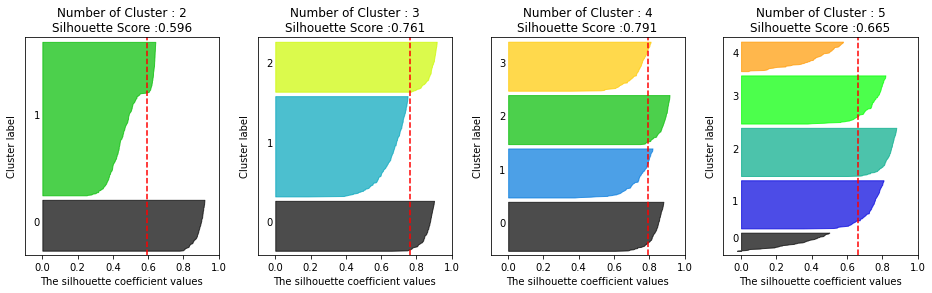

In [93]:
# 4처럼 응집도와 분리도가 좋은 군집 갯수가 가장 이상적
kmens.visualize_silhouette([2,3,4,5])

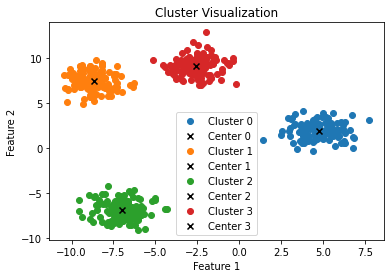

In [94]:
kmens.visualize_clusters(4)